In [1]:
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+983633da53 	w_latest w_2021_16 current setup


## Prequisities 

The open-sesame command to run this pipetask:
```
source /u/ek/echarles/lsst/software/stable/config/lsst.bashrc
lsst_setup w_2021_16
```
In addition to the normal setup, we need to enable mixcoatl by commanding
```
export PYTHONPATH="/gpfs/slac/lsst/fs1/g/data/youtsumi/Spot/mixcoatl/python":${PYTHONPATH}
```
The yaml file I used is here: https://github.com/youtsumi/ButlerGen3Work/blob/master/cpSpot2.yaml

And then the comamnd to run (the following command only runs for a single image)
```
pipetask run \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_test \
    -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_12781 \
    -d "instrument='LSSTCam' AND detector=29 AND exposure.observation_type='spot' AND exposure.science_program IN ('12788') AND exposure.seq_num=1820" \
    -o u/youtsumi/spot/20210504a \
    -p /u/ki/youtsumi/gpfs/Spot/cpSpot2.yaml \
    --register-dataset-types
```

I used the following command to process all the images belonging to runs 12784, 12785, 12788, 12789
```
pipetask run \
    -b /sdf/group/lsst/camera/IandT/repo_gen3/spot_test \
    -i LSSTCam/raw/all,LSSTCam/calib,/calib/run_12781 \
    -d "instrument='LSSTCam' AND detector=29 AND exposure.observation_type='spot' AND exposure.science_program IN ('12784', '12785', '12788', '12789')" \
    -o u/youtsumi/spot/Nov2020 \
    -p /u/ki/youtsumi/gpfs/Spot/cpSpot2.yaml \
    --register-dataset-types -j 4
```


The mixcoatl version I used was
https://github.com/youtsumi/mixcoatl/

You can prune Run collection by commanding like
```
butler prune-collection /sdf/group/lsst/camera/IandT/repo_gen3/spot_test/butler.yaml u/youtsumi/spot/junk/20210506T014808Z  --purge --unstore
```

## After the pipetask finished, we will explore what are generated in this Jupyter Notebook

First we will see what's collection available in this Butler repository

In [2]:
# Import necessary libraries
from lsst.daf.butler import Butler
%matplotlib inline

import pylab as plt
# Stack imports
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

import numpy

# point to the Repo we are working on, these lines will print out what's in the Repo.
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/butler.yaml"
butler = Butler(repo_path)
registry = butler.registry
for c in registry.queryCollections():
    print(c)    

LSSTCam/raw/all
u/echarles/calib/run_12781
u/echarles/calib/run_12781/20210322T182107Z
/calib/run_12781
u/echarles/calib/bias/run_12781
u/echarles/calib/bias/run_12781/20210322T183606Z
LSSTCam/calib
LSSTCam/calib/unbounded
u/echarles/calib/run_12783/dark
u/echarles/calib/run_12783/dark/20210322T202029Z
u/echarles/calib/defects/run_12781
u/echarles/calib/defects/run_12781/20210322T224240Z
u/echarles/sandbox/eo_bias
u/echarles/sandbox/eo_bias/20210324T033754Z
u/echarles/calib/bias/run_12781/20210324T162502Z
u/echarles/calib/run_12783/dark/20210324T163856Z
u/echarles/calib/defects/run_12781/20210324T164529Z
u/youtsumi/spot/20210324
u/youtsumi/spot/20210324/20210325T013830Z
u/youtsumi/spot/20210324a
u/youtsumi/spot/20210324a/20210325T034308Z
u/youtsumi/spot/20210324c
u/youtsumi/spot/20210324c/20210325T041707Z
u/echarles/calib/bias/run_12781/20210326T180033Z
u/youtsumi/spot/20210402a
u/youtsumi/spot/20210402a/20210402T185535Z
u/youtsumi/spot/20210402b
u/youtsumi/spot/20210402b/20210402T1900

In [3]:
# Specify collection. I know 'u/youtsumi/spot/20210504b' is the one. So pick it
collections = 'u/youtsumi/spot/20210504b'
#collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'

# then explore the inside of the collection
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

79124 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpBiasProc_full', {band, instrument, detector, physical_filter, exposure}, Exposure)
1292 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('bias_full', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
2 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
2 DatasetType('packages', {}, Packages)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
Error DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDark_metadata', {band, instrument, det

Load all catalog onto memory, will take an hour

In [4]:
datasetRefs = list(subregistry.queryDatasets(
    datasetType="gridSpotSrc",
    collections=collections)
                  )
results = []

for aref in datasetRefs[:]:
    try:
        # get a catalog from the butler
        src = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        md = subbutler.get("raw",dataId=aref.dataId).getMetadata()
        # stores into memory for later use
        results.append( {"md": md, "src":src} )
    except:
#        raise
        pass

/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/LSSTCam/raw/all/raw/20201125/MC_C_20201125_001787/raw_LSSTCam_unknown_MC_C_20201125_001787_R10_S02_LSSTCam_raw_all.fits(MC_C_20201125_001787): Unable to determine the filter
/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/LSSTCam/raw/all/raw/20201125/MC_C_20201125_001362/raw_LSSTCam_unknown_MC_C_20201125_001362_R10_S02_LSSTCam_raw_all.fits(MC_C_20201125_001362): Unable to determine the filter
/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/LSSTCam/raw/all/raw/20201125/MC_C_20201125_001691/raw_LSSTCam_unknown_MC_C_20201125_001691_R10_S02_LSSTCam_raw_all.fits(MC_C_20201125_001691): Unable to determine the filter
/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/LSSTCam/raw/all/raw/20201126/MC_C_20201126_000486/raw_LSSTCam_unknown_MC_C_20201126_000486_R10_S02_LSSTCam_raw_all.fits(MC_C_20201126_000486): Unable to determine the filter
/sdf/group/lsst/camera/IandT/repo_gen3/spot_test/LSSTCam/raw/all/raw/20201125/MC_C_20201125_001602/raw_LSSTC

Display a result

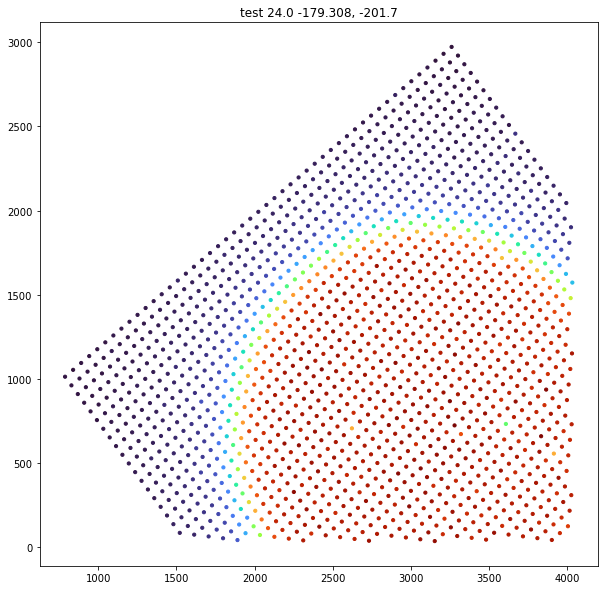

In [5]:
acat = results[0]["src"]
md = results[0]["md"]
fig = plt.figure(figsize=(10,10))
plt.title("{} {} {}, {}".format(
    "test",
    md["EXPTIME"],
    md["BOTXCAM"],
    md["BOTYCAM"]
))

fluxkey = "base_CircularApertureFlux_35_0_instFlux"

x, y = acat["spotgrid_x"], acat["spotgrid_y"]
I = acat[fluxkey]
plt.scatter( x, y, c=(I/numpy.nanmax(I)), s=10,cmap='turbo')


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_16/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.5.0-ext/lib/python3.8/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, 'base_CircularApertureFlux_35_0_instFlux')

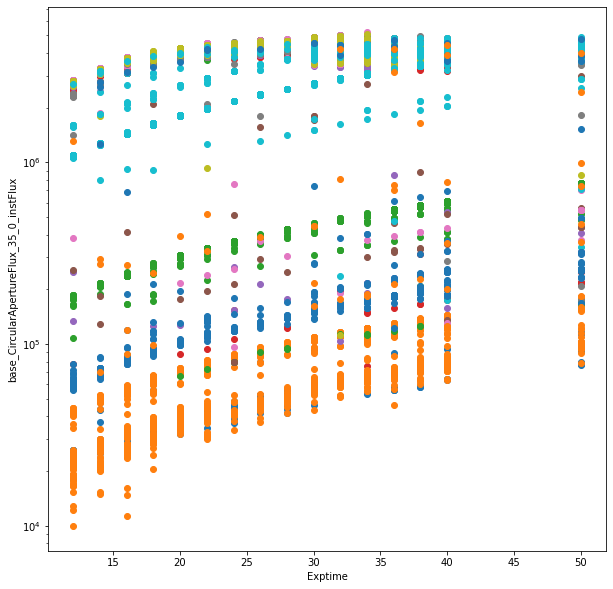

In [6]:
from astropy.table import Table, join, hstack
indexes = numpy.arange(2400)
basetable = ( Table( [ indexes+1,], names=("Index",) ) )

# sorting tables, padding missing, and joining tables in an order of fiducial spots
arr = []
for aresult in results:
    table = (Table( [
            aresult["src"]["spotgrid_index"],
            aresult["src"][fluxkey] 
        ],
        names=("Index","Iarr"),
        meta={ "exptime": aresult["md"]["EXPTIME"] } ))
    arr.append( join( basetable, table, keys="Index", join_type="left" )["Iarr"] )
arr = hstack([*arr])

# plots each spot fluxes as a function of exposure time
fig = plt.figure(figsize=(10,10))
for i in indexes[::200]:
    I = list(arr[i].values())
    plt.plot( [ aresult["md"]["EXPTIME"] for aresult in results ] , I, "o" )

plt.semilogy()
plt.xlabel( "Exptime" )
plt.ylabel( fluxkey )